In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from os.path import join
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from scipy.stats import pearsonr
from IPython.display import display

rng_seed = 399
np.random.seed(rng_seed)
import persim
import joblib

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV, LogisticRegressionCV
from sklearn.preprocessing import minmax_scale, RobustScaler

import tensorflow as tf

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], "GPU")
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != "GPU"
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Directory constants
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")

# Extend sys path for importing custom Python files
import sys

sys.path.append(root_code_dir)

from topological_data_analysis.topological_polysemy import tps
from word_embeddings.word2vec import load_model_training_output

<IPython.core.display.Javascript object>

## Prepare data

In [3]:
word_meaning_train_data = pd.read_csv("data/word_meaning_train_data.csv")
word_meaning_test_data = pd.read_csv("data/word_meaning_test_data.csv")
word_meaning_semeval_test_data = pd.read_csv("data/word_meaning_semeval_test_data.csv")
word_meaning_data_cols = word_meaning_train_data.columns.values
word_meaning_data_feature_cols = np.array(
    [col for col in word_meaning_data_cols if col.startswith("X_")]
)

<IPython.core.display.Javascript object>

In [4]:
print("Train")
word_meaning_train_data

Train


,word,y,X_tps_10,X_tps_10_pd_max,X_tps_10_pd_avg,X_tps_10_pd_std,X_tps_20,X_tps_20_pd_max,X_tps_20_pd_avg,X_tps_20_pd_std,...,X_gad_knn_50_250_P_int,X_gad_knn_50_550_P_bnd,X_gad_knn_50_550_P_man,X_gad_knn_50_550_P_int,X_gad_knn_50_750_P_bnd,X_gad_knn_50_750_P_man,X_gad_knn_50_750_P_int,X_gad_knn_100_1000_P_bnd,X_gad_knn_100_1000_P_man,X_gad_knn_100_1000_P_int
0,in,7,4.248133,1.046609,0.523305,0.523305,8.200863,1.022337,0.511169,0.511169,...,0,1,0,0,1,0,0,1,0,0
1,a,7,3.850081,1.026458,0.513229,0.513229,7.565535,1.022583,0.511291,0.511291,...,0,1,0,0,1,0,0,1,0,0
2,thousand,2,3.770527,1.035653,0.517826,0.517826,7.150504,1.003230,0.501615,0.501615,...,0,1,0,0,1,0,0,1,0,0
3,one,9,2.174424,0.732104,0.366052,0.366052,4.876410,0.860300,0.430150,0.430150,...,0,1,0,0,1,0,0,1,0,0
4,hundred,2,4.093440,1.042251,0.521126,0.521126,8.360992,1.045908,0.522954,0.522954,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137093,kichais,1,3.750899,0.990532,0.495266,0.495266,7.905969,0.945381,0.472691,0.472691,...,0,1,0,0,1,0,0,1,0,0
137094,hassams,1,4.690177,1.096302,0.548151,0.548151,9.694982,1.109408,0.554704,0.554704,...,0,1,0,0,1,0,0,1,0,0
137095,bisters,1,4.543681,1.060358,0.530179,0.530179,8.981394,1.036390,0.518195,0.518195,...,0,1,0,0,1,0,0,1,0,0
137096,obstructor,2,4.324607,1.028723,0.514361,0.514361,8.734713,1.024522,0.512261,0.512261,...,0,1,0,0,1,0,0,1,0,0


<IPython.core.display.Javascript object>

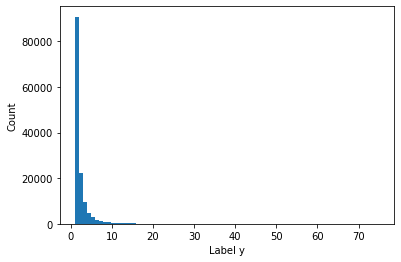

<IPython.core.display.Javascript object>

In [5]:
plt.hist(word_meaning_train_data["y"], bins=word_meaning_train_data["y"].max())
plt.xlabel("Label y")
plt.ylabel("Count")
plt.show()

In [6]:
print("Test")
word_meaning_test_data

Test


,word,y,X_tps_10,X_tps_10_pd_max,X_tps_10_pd_avg,X_tps_10_pd_std,X_tps_20,X_tps_20_pd_max,X_tps_20_pd_avg,X_tps_20_pd_std,...,X_gad_knn_50_250_P_int,X_gad_knn_50_550_P_bnd,X_gad_knn_50_550_P_man,X_gad_knn_50_550_P_int,X_gad_knn_50_750_P_bnd,X_gad_knn_50_750_P_man,X_gad_knn_50_750_P_int,X_gad_knn_100_1000_P_bnd,X_gad_knn_100_1000_P_man,X_gad_knn_100_1000_P_int
0,as,10,4.317206,1.077280,0.538640,0.538640,8.057132,1.077280,0.538640,0.538640,...,0,1,0,0,1,0,0,1,0,0
1,eight,4,4.294665,1.093943,0.546971,0.546971,8.501568,1.037538,0.518769,0.518769,...,0,1,0,0,1,0,0,1,0,0
2,time,15,3.427256,0.885813,0.442906,0.442906,6.465290,0.885813,0.442906,0.442906,...,0,1,0,0,1,0,0,1,0,0
3,under,10,4.190029,1.127449,0.563724,0.563724,8.322828,1.012981,0.506491,0.506491,...,0,1,0,0,1,0,0,1,0,0
4,well,22,3.179627,0.774289,0.387145,0.387145,6.710519,0.740595,0.370297,0.370297,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211,effs,1,4.354566,1.004452,0.502226,0.502226,8.303034,1.004085,0.502042,0.502042,...,0,1,0,0,1,0,0,1,0,0
7212,pushful,1,4.256451,1.005711,0.502855,0.502855,8.527463,0.969283,0.484641,0.484641,...,0,1,0,0,1,0,0,1,0,0
7213,coapted,2,4.131102,0.962983,0.481492,0.481492,8.338664,0.965748,0.482874,0.482874,...,0,1,0,0,1,0,0,1,0,0
7214,troponyms,1,4.151853,1.018178,0.509089,0.509089,8.882389,1.034668,0.517334,0.517334,...,0,1,0,0,1,0,0,1,0,0


<IPython.core.display.Javascript object>

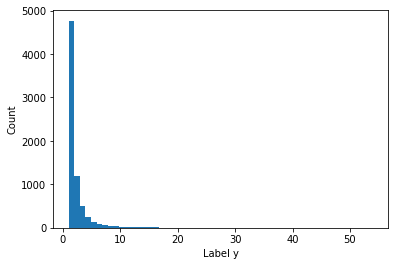

<IPython.core.display.Javascript object>

In [7]:
plt.hist(word_meaning_test_data["y"], bins=word_meaning_test_data["y"].max())
plt.xlabel("Label y")
plt.ylabel("Count")
plt.show()

In [8]:
# Split into X and y
X_train = minmax_scale(word_meaning_train_data[word_meaning_data_feature_cols].values)
X_test = minmax_scale(word_meaning_test_data[word_meaning_data_feature_cols].values)
X_test_semeval = minmax_scale(
    word_meaning_semeval_test_data[word_meaning_data_feature_cols].values
)
y_train = word_meaning_train_data["y"].values
y_test = word_meaning_test_data["y"].values
y_test_semeval = word_meaning_semeval_test_data["y"].values

<IPython.core.display.Javascript object>

In [9]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(
        word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"
    ),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True,
)
last_embedding_weights_normalized = w2v_training_output[
    "last_embedding_weights_normalized"
]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]
word_counts = w2v_training_output["word_counts"]

<IPython.core.display.Javascript object>

In [10]:
# Load SemEval-2010 task 14 words
semeval_2010_14_word_senses = joblib.load(
    join(
        "..", "topological_data_analysis", "data", "semeval_2010_14_word_senses.joblib"
    )
)
semeval_target_words = np.array(list(semeval_2010_14_word_senses["all"].keys()))
semeval_target_words_in_vocab_filter = [
    i for i, word in enumerate(semeval_target_words) if word in word_to_int
]
semeval_target_words_in_vocab = semeval_target_words[
    semeval_target_words_in_vocab_filter
]
semeval_gs_clusters = np.array(list(semeval_2010_14_word_senses["all"].values()))
semeval_gs_clusters_in_vocab = semeval_gs_clusters[semeval_target_words_in_vocab_filter]

num_semeval_words = len(semeval_target_words_in_vocab)

<IPython.core.display.Javascript object>

## Do modeling

In [11]:
def plot_pred_vs_true_labels(
    pred_labels: np.ndarray, true_labels: np.ndarray, xlabel: str, ylabel: str
) -> None:
    """
    TODO: Docs
    """
    pred_true_corr, _ = pearsonr(pred_labels, true_labels)
    pred_true_mse = mean_squared_error(true_labels, pred_labels)

    plt.figure(figsize=(10, 7))
    plt.scatter(pred_labels, true_labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"Pred/True: correlation: {pred_true_corr:.3f}, MSE: {pred_true_mse:.3f}")
    plt.show()

<IPython.core.display.Javascript object>

### Lasso regression with K-fold CV

In [12]:
# Parameters
cv = 20
max_iter = 100000
l1_alphas = np.linspace(0.00000001, 0.1, 10000)

<IPython.core.display.Javascript object>

In [ ]:
# Lasso regression
lasso_cv = LassoCV(
    alphas=l1_alphas,
    random_state=rng_seed,
    max_iter=max_iter,
    n_jobs=-1,
    cv=cv,
)
lasso_cv.fit(X_train, y_train)
print(f"Selected alpha: {lasso_cv.alpha_}")

In [ ]:
sorted_feature_weights_indices = np.argsort(np.abs(lasso_cv.coef_))[::-1]
sorted_features_arr = np.array(
    list(
        zip(
            word_meaning_data_feature_cols[sorted_feature_weights_indices],
            lasso_cv.coef_[sorted_feature_weights_indices],
        )
    )
)
sorted_features_df = pd.DataFrame(
    {"feature": sorted_features_arr[:, 0], "weight": sorted_features_arr[:, 1]}
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(sorted_features_df)

In [ ]:
y_pred = lasso_cv.predict(X_train)
plot_pred_vs_true_labels(
    y_pred, y_train, xlabel="Pred number of synsets", ylabel="Synsets in Wordnet"
)

In [ ]:
y_pred_test = lasso_cv.predict(X_test)
plot_pred_vs_true_labels(
    y_pred_test, y_test, xlabel="Pred number of meanings", ylabel="Clusters in GS"
)

In [ ]:
y_pred_test_semeval = lasso_cv.predict(X_test_semeval)
plot_pred_vs_true_labels(
    y_pred_test_semeval,
    y_test_semeval,
    xlabel="Pred number of meanings",
    ylabel="Clusters in GS",
)

### Multi-class logistic regression with L1-penalty, finding optimal alpha with K-fold CV

In [13]:
def create_multi_class_labels(labels: np.ndarray, max_label: int) -> np.ndarray:
    multi_class_labels = np.zeros_like(labels)
    for i, label in enumerate(labels):
        if label > max_label:
            multi_class_labels[i] = max_label
        else:
            multi_class_labels[i] = label - 1
    return multi_class_labels

<IPython.core.display.Javascript object>

In [14]:
# Create multi-class labels
max_y_multi = np.quantile(y_train, q=0.9)
y_train_multi_class = create_multi_class_labels(labels=y_train, max_label=max_y_multi)
y_test_multi_class = create_multi_class_labels(labels=y_test, max_label=max_y_multi)

<IPython.core.display.Javascript object>

In [15]:
# Load result from training
log_reg_cv = joblib.load("data/log_reg_cv.joblib")

<IPython.core.display.Javascript object>

In [27]:
log_reg_cv.C_

array([12.30343272, 12.30343272, 12.30343272, 12.30343272, 12.30343272])

<IPython.core.display.Javascript object>

In [23]:
labels_str = [
    str(label + 1) if i < 4 else "5_or_more"
    for i, label in enumerate(log_reg_cv.classes_)
]

<IPython.core.display.Javascript object>

In [18]:
df_dict = {}
for label_str, coeffs in zip(labels_str, log_reg_cv.coef_):
    sorted_feature_weights_indices = np.argsort(np.abs(coeffs))[::-1]
    df_dict[f"feature_{label_str}"] = word_meaning_data_feature_cols[
        sorted_feature_weights_indices
    ]
    df_dict[f"weight_{label_str}"] = coeffs[sorted_feature_weights_indices]

sorted_features_df = pd.DataFrame(df_dict)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(sorted_features_df)

,feature_1,weight_1,feature_2,weight_2,feature_3,weight_3,feature_4,weight_4,feature_5_or_more,weight_5_or_more
0,X_tps_90,5.483908,X_tps_100,2.185979e+00,X_tps_70,-2.582598,X_tps_50,3.058629,X_tps_60,-3.016208
1,X_estimated_id_mle,-3.064712,X_tps_90,1.452512e+00,X_tps_60,1.893363,X_tps_70,-2.250088,X_estimated_id_twonn,-2.661173
2,X_estimated_id_twonn,1.824396,X_tps_80,-1.269355e+00,X_tps_80,1.518900,X_tps_60,-2.213706,X_tps_40,1.521031
3,X_tps_40,-1.664799,X_tps_40,-1.092723e+00,X_tps_50,-0.773635,X_estimated_id_twonn,-0.950775,X_tps_90,-1.236191
4,X_estimated_id_lpca,-1.562936,X_estimated_id_twonn,1.064382e+00,X_tps_20,0.698459,X_tps_80,0.908643,X_tps_30,0.971987
5,X_tps_70,1.466333,X_estimated_id_mle,-8.276505e-01,X_tps_90,-0.543088,X_tps_30,-0.747436,X_tps_50,0.873222
6,X_tps_80,-1.035988,X_gad_knn_25_500_P_man,7.751104e-01,X_tps_30,-0.542539,X_estimated_id_mle,0.509994,X_estimated_id_mle,0.738282
7,X_tps_100,0.960664,X_gad_knn_25_250_P_man,7.751104e-01,X_tps_40,0.453907,X_tps_40_pd_std,0.363469,X_tps_100,-0.684237
8,X_tps_20,-0.596228,X_estimated_id_lpca,-7.556746e-01,X_tps_80_pd_avg,-0.244154,X_tps_40_pd_avg,0.363469,X_estimated_id_lpca,0.636306
9,X_tps_10,-0.443040,X_tps_30,6.174733e-01,X_tps_80_pd_std,-0.244154,X_tps_40_pd_max,0.363469,X_tps_10_pd_avg,0.422329


<IPython.core.display.Javascript object>

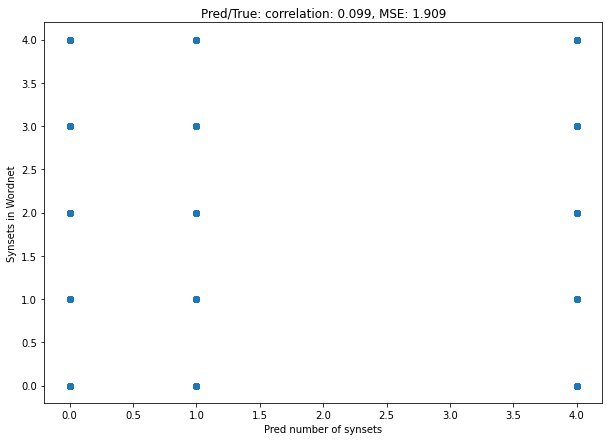

<IPython.core.display.Javascript object>

In [19]:
y_pred = log_reg_cv.predict(X_train)
plot_pred_vs_true_labels(
    y_pred,
    y_train_multi_class,
    xlabel="Pred number of synsets",
    ylabel="Synsets in Wordnet",
)

In [20]:
from sklearn.metrics import f1_score, multilabel_confusion_matrix, plot_confusion_matrix
import seaborn as sns

f1_score(y_train_multi_class, y_pred, average="weighted")

0.5334992817348921

<IPython.core.display.Javascript object>

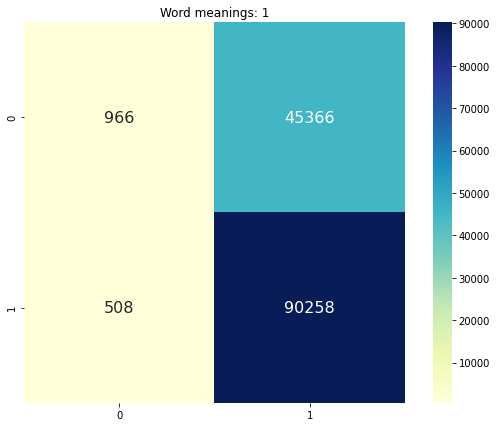

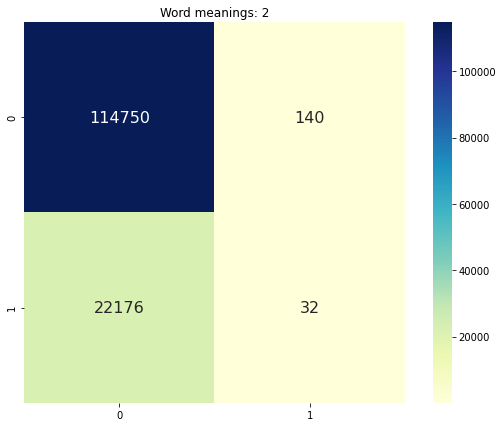

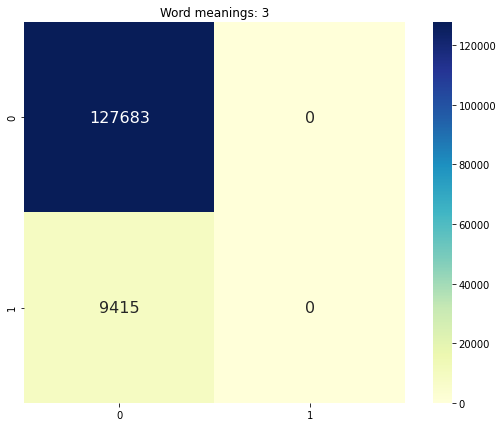

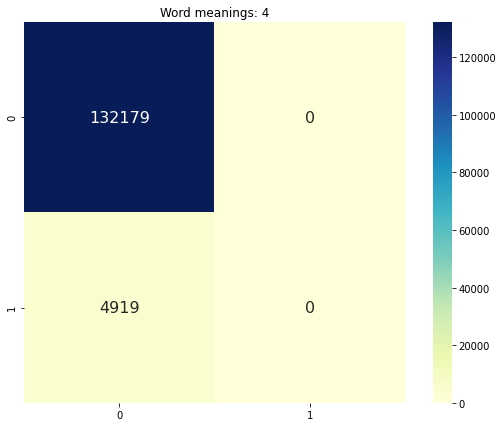

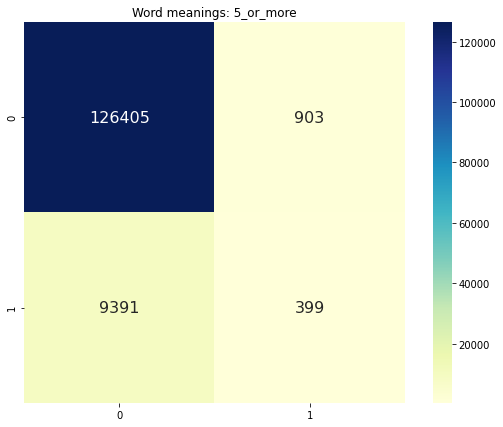

<IPython.core.display.Javascript object>

In [35]:
cms = multilabel_confusion_matrix(y_train_multi_class, y_pred)
for label_str, cm in zip(labels_str, cms):
    _, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(f"Word meanings: {label_str}")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    sns.heatmap(
        cm,
        cmap="YlGnBu",
        annot=True,
        fmt="d",
        annot_kws={"size": 16},
        square=True,
        ax=ax,
    )